In [ ]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 2.0MB 5.7MB/s 
     |████████████████████████████████| 3.3MB 36.3MB/s 
     |████████████████████████████████| 870kB 39.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=8a0eeaa21c410087abc1cd083727285b85f0b34585fc59160b84b3ee6cd8738e
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 194kB 5.4MB/s 
     |████████████████████████████████| 112kB 7.7MB/s 
     |████████████████████████████████| 245kB 7.4MB/s 


In [ ]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-fv1zpp1d
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-fv1zpp1d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.5.0.dev0-cp37-none-any.whl size=2059806 sha256=c71a175a1a21fb4f61aa2f3feac8761982f3b954f562075fdaf513f3f87b692c
  Stored in directory: /tmp/pip-ephem-wheel-cache-w1iv5239/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers
  Found existing installation: transformers 4.4.2
    Uninstalling transformers-4.4.2:
      Successfully uninstalled transformers-4.4.2


### Clone github repo for transformers

In [ ]:
!git clone https://github.com/huggingface/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 68938 (delta 63), reused 74 (delta 36), pack-reused 68803
Receiving objects: 100% (68938/68938), 52.50 MiB | 19.89 MiB/s, done.
Resolving deltas: 100% (48776/48776), done.


In [ ]:
cd /content/transformers/examples/language-modeling

/content/transformers/examples/language-modeling


In [ ]:
!python run_mlm.py \
    --model_name_or_path bert-base-cased \
    --train_file /content/train_preprocessed.txt \
    --validation_file /content/dev_preprocessed.txt \
    --do_train \
    --do_eval \
    --output_dir /content/bert_model

2021-04-06 16:21:07.997063: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
04/06/2021 16:21:09 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
04/06/2021 16:21:09 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/bert_model, overwrite_output_dir=False, do_train=True, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=8, per_device_eval_batch_size=8, gradient_accumulation_steps=1, eval_accumulation_steps=None, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/Apr06_16-21-09_82fb2eb025ff, logging_strategy=IntervalStrategy.STEPS, logging_first_st

### Now use pytorch_model.bin (model weights from language model training) to fine tune our classification task.

In [ ]:
# import required libraries
import pandas as pd
import numpy as np
import time
import datetime
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve,auc,f1_score

from statistics import mean

import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification,BertConfig
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader,TensorDataset, RandomSampler, SequentialSampler
import torch.nn as nn  
import torch.nn.functional as F  
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu');

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
color_palette=['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(color_palette))

rcParams['figure.figsize']= 12,6

import warnings
warnings.filterwarnings('ignore')

seed=42
np.random.seed(seed)
torch.manual_seed(seed)

### Read the datasets

In [ ]:
# Train dataset
df_train=pd.read_csv('/content/train_preprocessed.csv')
print('There are {} observations (tweets) & {} features in the Train dataset'.format(df_train.shape[0],df_train.shape[1]))
print('Look at the Train dataset:')
df_train.head()

There are 528 observations (tweets) & 2 features in the Train dataset
Look at the Train dataset:


,claim,label
0,Viral image Says BBC prematurely reported “Ghi...,false
1,The coronavirus is “simply the common cold.”,false
2,Instagram posts Says no one has died from the ...,false
3,An audio message lists five ways people can pr...,false
4,"This is COVID-19, not COVID-1, folks. And so y...",false


In [ ]:
# Validation dataset
df_dev=pd.read_csv('/content/dev_preprocessed.csv')
print('There are {} observations (tweets) & {} features in the Train dataset'.format(df_dev.shape[0],df_dev.shape[1]))
print('Look at the Validation (dev) dataset:')
df_dev.head()

There are 69 observations (tweets) & 2 features in the Train dataset
Look at the Validation (dev) dataset:


,claim,label
0,"Microsoft owns patent ""666,"" which involves in...",false
1,The seasonal flu kills more people every year ...,false
2,“President Trump has come into contact with a ...,false
3,Sanitizer will do nothing for the coronavirus.,false
4,"Chain message Says ""special military helicopte...",false


In [ ]:
# Test dataset
df_test=pd.read_csv('/content/test_preprocessed.csv')
print('There are {} observations (tweets) & {} features in the Train dataset'.format(df_test.shape[0],df_test.shape[1]))
print('Look at the Test dataset:')
df_test.head()

There are 68 observations (tweets) & 2 features in the Train dataset
Look at the Test dataset:


,claim,label
0,Viral image Says 80% of novel coronavirus case...,true
1,“While California is dying … Gavin (Newsom) is...,false
2,The WHO coronavirus test “was a bad test.”,false
3,"Facebook post Says ""there is no"" COVID-19 virus.",false
4,Facebook post Says businesses will give you fr...,false


Let's check missing values if there are any.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   claim   528 non-null    object
 1   label   528 non-null    object
dtypes: object(2)
memory usage: 8.4+ KB


In [ ]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   claim   69 non-null     object
 1   label   69 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   claim   68 non-null     object
 1   label   68 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


We have not found any null values in train, dev, & test dataset.

### Count plot for label

Text(0.5, 0, 'label')

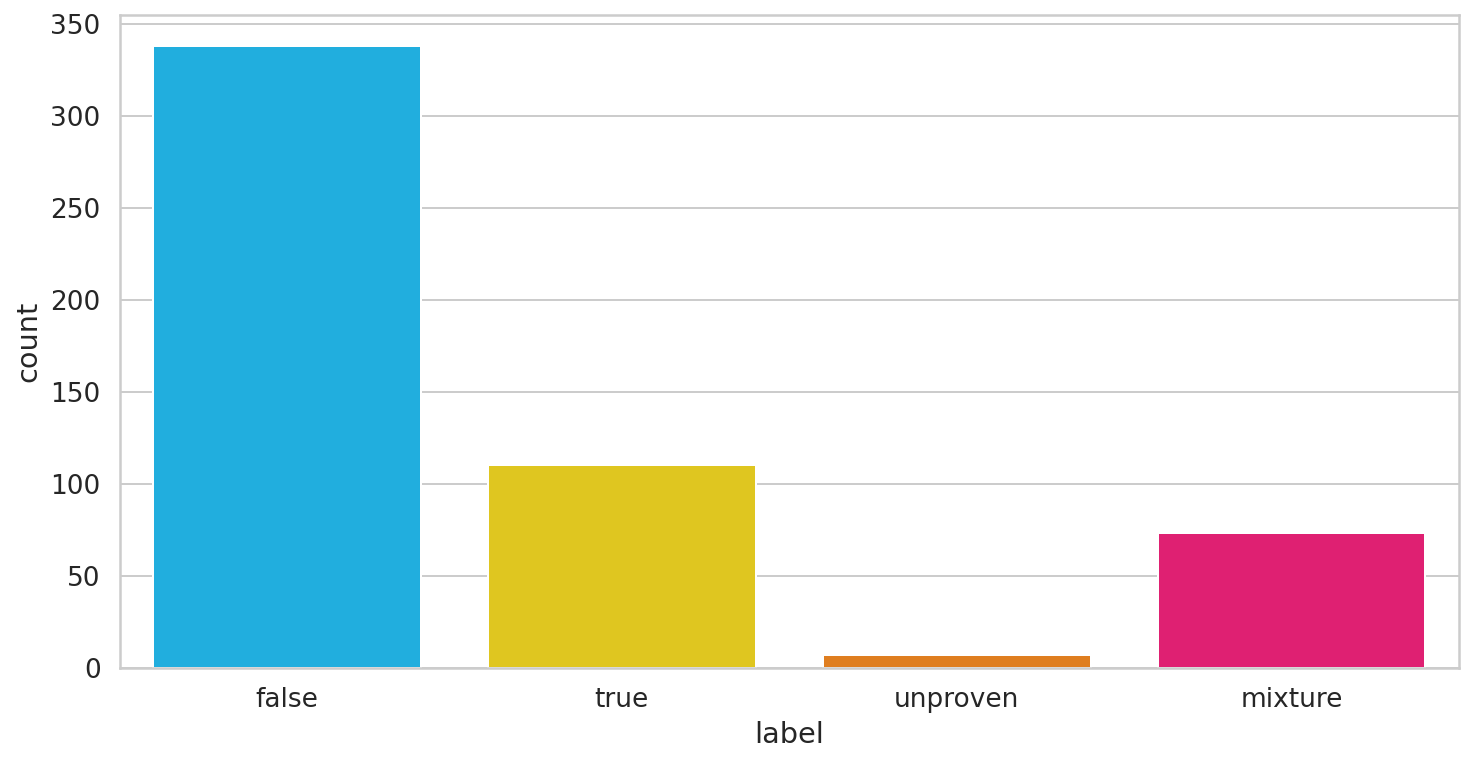

In [ ]:
sns.countplot(df_train.label)
plt.xlabel('label')

We need only 3 classes (false, true, & mixture) for this task. So drop unproven class from dataset.

Train dataset shape : (521, 2)


Text(0.5, 0, 'label')

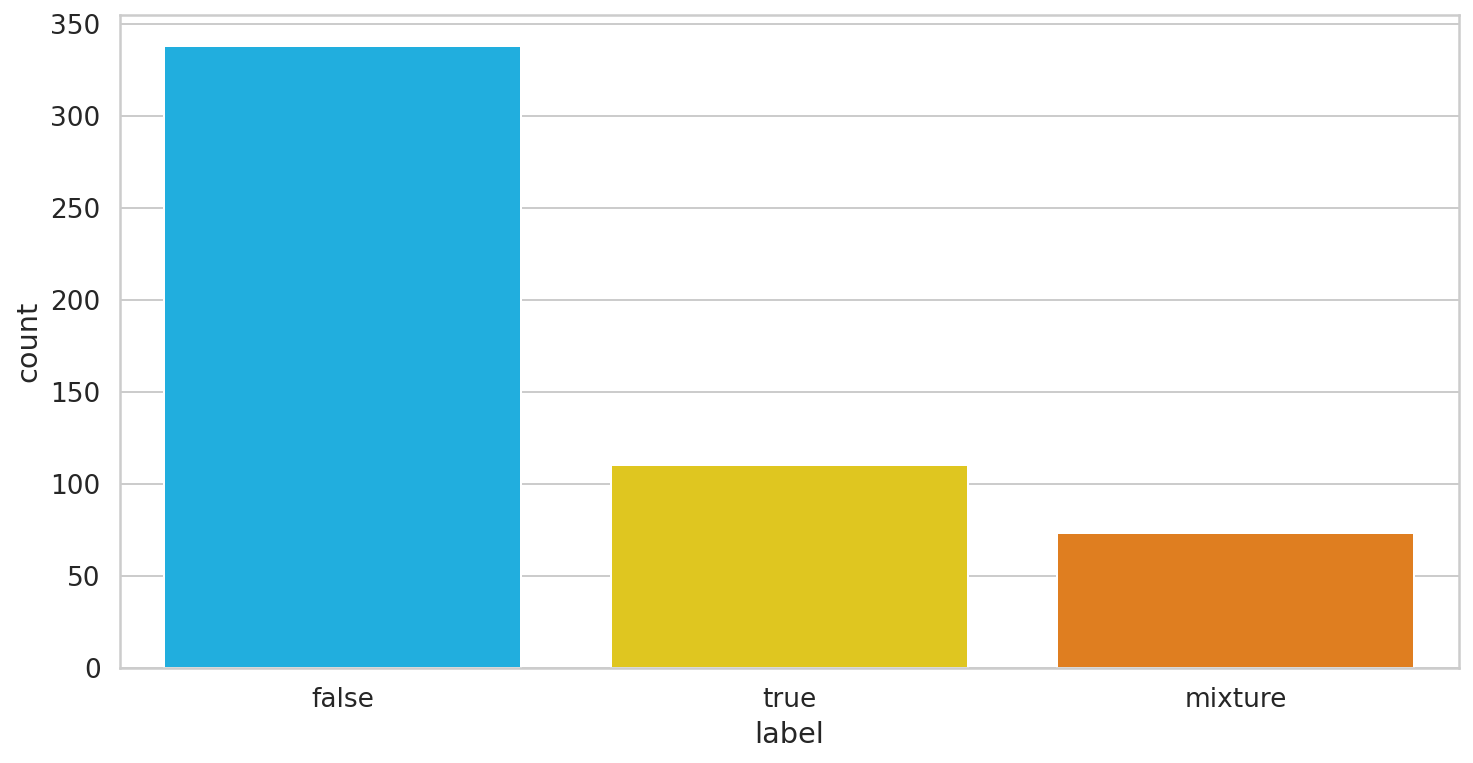

In [ ]:
df_train=df_train[~(df_train.label=='unproven')]
print('Train dataset shape : {}'.format(df_train.shape))
sns.countplot(df_train.label)
plt.xlabel('label')

### Encode out text labels to numeric.

In [ ]:
# Initiate LabelEncoder class
le =LabelEncoder()
# Training dataset
df_train['label'] = le.fit_transform(df_train['label'])
df_train.label.value_counts()   # 0 -false, 2-true, 1-mixture

0    338
2    110
1     73
Name: label, dtype: int64

In [ ]:
# Dev dataset
df_dev=df_dev[~(df_dev.label=='unproven')]   # only 3 classes
df_dev['label'] = le.transform(df_dev['label'])
df_dev.label.value_counts()   # 0 -false, 2-true, 1-mixture

0    51
2    10
1     6
Name: label, dtype: int64

In [ ]:
# Test dataset
df_test=df_test[~(df_test.label=='unproven')]   # only 3 classes
df_test['label'] = le.transform(df_test['label'])
df_test.label.value_counts()   # 0 -false, 2-true, 1-mixture

0    49
2    13
1     6
Name: label, dtype: int64

### Define pre-trained model

In [ ]:
Pre_trained_model='bert-base-cased'
custom_model = '/content/bert_model/'   # fine tuned language model weights

### Load the BERT tokenizer:

In [ ]:
tokenizer=BertTokenizer.from_pretrained(Pre_trained_model)

In [ ]:
# Convert to list
train_explanations = df_train.explanation.tolist()
dev_explanations = df_dev.explanation.tolist()
test_explanations = df_test.explanation.tolist()

In [ ]:
# Create token ids (input ids) for each explanation
# Train dataset
train_input_ids = [tokenizer.encode(train_explanations[i],add_special_tokens = True) for i in range(0,len(train_explanations))]
# dev dataset
dev_input_ids = [tokenizer.encode(dev_explanations[i],add_special_tokens = True) for i in range(0,len(dev_explanations))]
# Test dataset
test_input_ids = [tokenizer.encode(test_explanations[i],add_special_tokens = True) for i in range(0,len(test_explanations))]

### Padding & Truncating

Pad and truncate our sequences so that they all have the same length, Maximum explanation length.

In [ ]:
print('Max explanation length for train data: ', max([len(exp) for exp in train_input_ids]))
print('Max explanation length for dev/validation data: ', max([len(exp) for exp in dev_input_ids]))
print('Max explanation length for test data: ', max([len(exp) for exp in test_input_ids]))

Max explanation length for train data:  296
Max explanation length for dev/validation data:  228
Max explanation length for test data:  171


In [ ]:
from keras.preprocessing.sequence import pad_sequences    # Pad utility function to pad sequences to maximum length.
 
# Train dataset
Max_length = 320   # We consider maximum length of explanations more than 296 just to be on safer side.
print('\nPadding/truncating all sentences to %d values for train dataset...' % Max_length)
# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence
train_input_ids = pad_sequences(train_input_ids, maxlen=Max_length, dtype="long", 
                          value=0, truncating="post", padding="post")

# dev dataset
Max_length = 228   # We consider maximum length of explanations more than 250 just to be on safer side.
print('\nPadding/truncating all sentences to %d values for dev dataset...' % Max_length)
dev_input_ids = pad_sequences(dev_input_ids, maxlen=Max_length, dtype="long", 
                          value=0, truncating="post", padding="post")

# Test dataset
Max_length = 171   # We consider maximum length of explanations more than 200 just to be on safer side.
print('\nPadding/truncating all sentences to %d values for test dataset' % Max_length)
test_input_ids = pad_sequences(test_input_ids, maxlen=Max_length, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\n All are done.')


Padding/truncating all sentences to 320 values for train dataset...

Padding/truncating all sentences to 228 values for dev dataset...

Padding/truncating all sentences to 171 values for test dataset

 All are done.


### Attention Masks

In [ ]:
# Create attention masks

# Train dataset
train_attention_masks = [[int(token_id > 0) for token_id in exp]
                         for exp in train_input_ids]
# dev dataset
dev_attention_masks = [[int(token_id > 0) for token_id in exp]
                         for exp in dev_input_ids]
# Test dataset
test_attention_masks = [[int(token_id > 0) for token_id in exp]
                         for exp in test_input_ids]

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.

# input_ids
train_inputs = torch.tensor(train_input_ids)
dev_inputs = torch.tensor(dev_input_ids)
test_inputs = torch.tensor(test_input_ids)
# labels
train_labels = torch.tensor(df_train.label.values)
dev_labels = torch.tensor(df_dev.label.values)
test_labels = torch.tensor(df_test.label.values)
# attention masks
train_masks = torch.tensor(train_attention_masks)
dev_masks = torch.tensor(dev_attention_masks)
test_masks = torch.tensor(test_attention_masks)

In [ ]:
# Create a DataLoader to load our datasets

batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our dev set.
dev_data = TensorDataset(dev_inputs, dev_masks, dev_labels)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
data1 = next(iter(test_dataloader))
data1[2]

tensor([2, 0, 0, 0, 0, 0, 0, 0])

### Build a Fact Checking Classifier

### BertForSequenceClassification

In [ ]:
# Number of classes / labels
n_classes = df_train['label'].nunique()

In [ ]:
bert_model = BertForSequenceClassification.from_pretrained(custom_model,num_labels = n_classes,
                                                          output_attentions = False,output_hidden_states = False )

Some weights of the model checkpoint at /content/bert_model/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/bert_model/ and

In [ ]:
# Put our model in training mode as it is in evaluation mode by default
bert_model.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
## Move model to the GPU
bert_model = bert_model.to(device) 

### Optimizer & Learning Rate Scheduler

As per original paper on BERT, we will use AdamW optimizer for correcting weight decay. We will also use, linear scheduler with no warm up steps:

In [ ]:
epochs=10
# Define optimizer for updating weights
optimizer=AdamW(bert_model.parameters(),lr=5e-5)
total_steps=len(train_dataloader)*epochs

# Scheduler for learning rate change
scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
 # Define loss function & move it to GPU
loss_fn=nn.CrossEntropyLoss().to(device)

### Train our model

Define a function for calculating elapsed time.

In [ ]:
def format_time(elapsed):
    # Round to the nearest second
    elapsed_round = int(round(elapsed))
    # Format time in hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_round))

Define a function to calculate accuracy

In [ ]:
def accuracy(preds, labels):
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(preds == labels) / len(labels)

### Start training...

In [ ]:
# Store loss value for each epoch
loss_values = []

for epoch in range(0,epochs):
     
        # Perform forward pass over the training dataset
        print("\n ======== Epoch {:}/{:} ========".format(epoch+1,epochs))
        print('Training....')
        
        # Measure how long a epoch takes
        t0 = time.time()
        # Reset total loss for this epoch
        total_loss = 0
        
        # Put the model in training mode
        bert_model.train()
        
        # For each training batch
        for step,batch in enumerate(train_dataloader):
            # Update progress for 50 steps
            if step % 50 ==0 & step !=0:
                # Calculate elapsed time in minutes
                elapsed = format_time(time.time(),t0)
                # Report progress
                print(' Batch {:>5,} of {:>5,}. Elapsed:{:}.'.format(step,len(train_loader),elapsed))
            
            # Unpack training batch from trainloader & move to GPU
            b_input_ids = batch[0].to(device)  # 0 - input ids
            b_attention_mask = batch[1].to(device) # 1 - input masks
            b_labels = batch[2].to(device)     # 2 - labels
            
            # Clear default gradients accumulated in Pytorch
            bert_model.zero_grad()
            
            # Output the results
            outputs = bert_model(input_ids = b_input_ids,attention_mask = b_attention_mask,labels=b_labels) # Return tuple
            # Loss value from output
            loss = outputs[0]   # 0 - loss
            
            # Update total loss
            total_loss += loss.item()
            
            # Perform a backward pass to calculate gradients
            loss.backward()
            
            # To avoid exploding vanishing gradients problem,clip the norm of the gradients to 1.0
            torch.nn.utils.clip_grad_norm_(bert_model.parameters(),1.0)
            
            # Update the parameters (weights)
            optimizer.step()
            
            # Update the learning rate
            scheduler.step()
            
        # Calculate the average loss over training data
        avg_total_loss = total_loss/len(train_dataloader)
            
        # Store the loss values
        loss_values.append(avg_total_loss)
        
        print('\n Average training loss : {0:.2f}'.format(avg_total_loss))
        print('Training epoch took: {:}'.format(format_time(time.time()- t0)))
        
        ####### Validation #######
        # After each epoch perform validation to check model performance
        print('\n Running validation...')
        
        t0 = time.time()
        #put model in evaluation mode
        bert_model.eval()
        
        # Tracking variables
        eval_loss,eval_acc = 0,0
        nb_eval_steps,nb_eval_examples = 0,0
        
        # Evaluate dev data for each epoch
        for batch in dev_dataloader:
            # Move batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack inputs from dev dataloader
            b_input_ids,b_attention_mask,b_labels = batch
            # Tell model not to compute gradients to save memory & speed up validation
            with torch.no_grad():
                # Forward pass, calculate logit prediction
                outputs = bert_model(input_ids=b_input_ids,attention_mask=b_attention_mask)
            # logits are class probabilities & get them from outputs
            logits = outputs[0]
            
            # Move logits & labels to CPU
            logits = logits.detach().cpu().numpy()
            labels = b_labels.to('cpu').numpy()
                
            # Calculate accuracy for this batch
            eval_accuracy = accuracy(logits,labels)
                
            # Accumulate total evaluation accuracy
            eval_acc += eval_accuracy
                
            # Track the number of steps
            nb_eval_steps += 1
                
        # Report the final validation accuracy
        print(' Accuracy {0:.2f}'.format(eval_acc/nb_eval_steps))
        print(' Validation took : {:}'.format(format_time(time.time() - t0)))
            
            
print('\n Training completed!')


 ======== Epoch 1/10 ========
Training....

 Average training loss : 0.88
Training epoch took: 0:00:30

 Running validation...
 Accuracy 0.69
 Validation took : 0:00:01

 ======== Epoch 2/10 ========
Training....

 Average training loss : 0.70
Training epoch took: 0:00:32

 Running validation...
 Accuracy 0.61
 Validation took : 0:00:01

 ======== Epoch 3/10 ========
Training....

 Average training loss : 0.37
Training epoch took: 0:00:32

 Running validation...
 Accuracy 0.55
 Validation took : 0:00:01

 ======== Epoch 4/10 ========
Training....

 Average training loss : 0.17
Training epoch took: 0:00:32

 Running validation...
 Accuracy 0.71
 Validation took : 0:00:01

 ======== Epoch 5/10 ========
Training....

 Average training loss : 0.07
Training epoch took: 0:00:32

 Running validation...
 Accuracy 0.70
 Validation took : 0:00:01

 ======== Epoch 6/10 ========
Training....

 Average training loss : 0.01
Training epoch took: 0:00:32

 Running validation...
 Accuracy 0.66
 Valida

Let's look at training vs validation loss:

Text(0, 0.5, 'Loss')

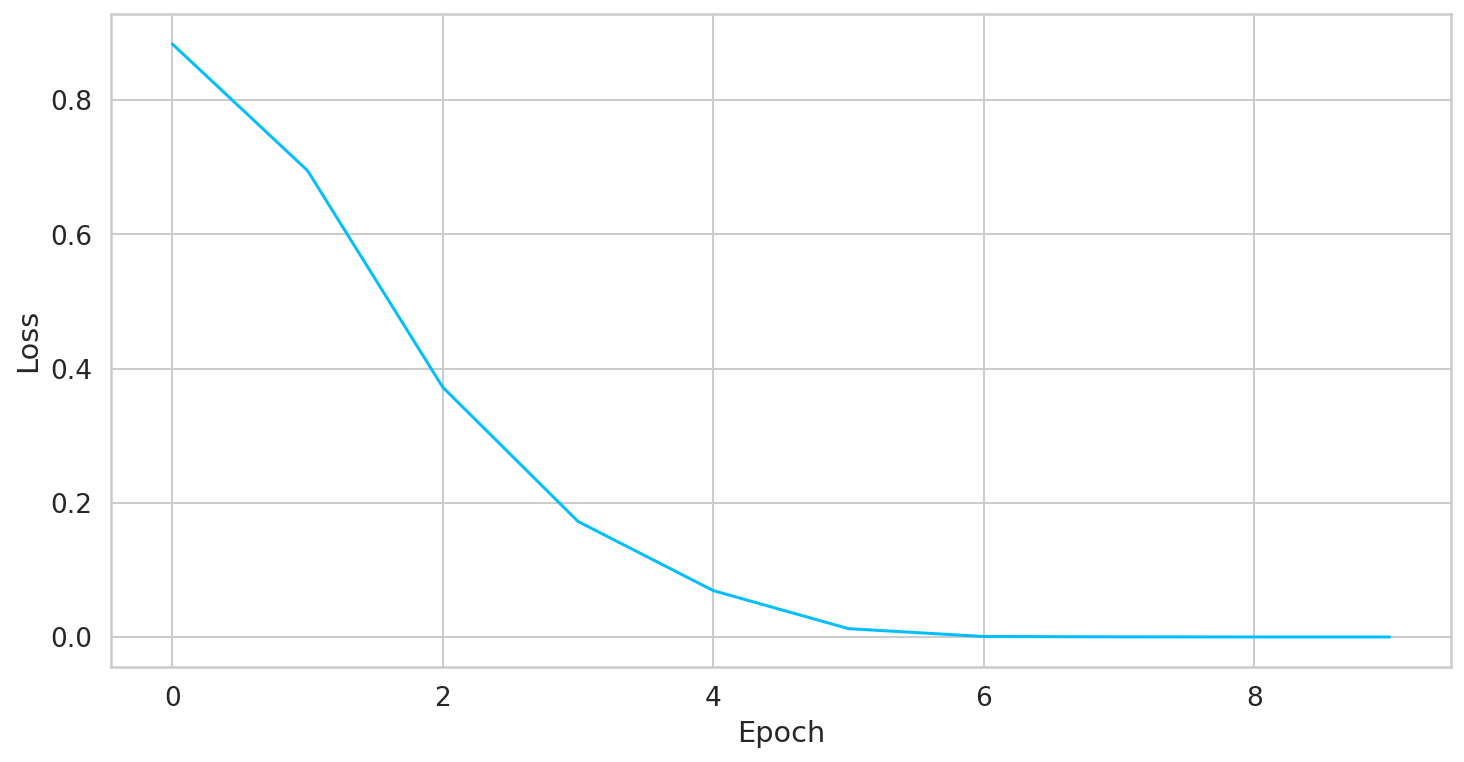

In [ ]:
df = pd.DataFrame(loss_values,columns=['Loss'])
sns.lineplot(data=df,x=df.index,y=df.Loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# Model performance on unseen data (test data)
print('\n Running testing on unseen data...')

#put model in evaluation model
bert_model.eval()

# Tracking variables
# Tracking variables
predictions , true_labels = [], []

# Evaluate test data
for batch in test_dataloader:
    # Move batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack inputs from test dataloader
    b_input_ids,b_attention_mask,b_labels = batch
    # Tell model not to compute gradients to save memory & speed up validation
    with torch.no_grad():
        # Forward pass, calculate logit prediction
        outputs = bert_model(input_ids=b_input_ids,attention_mask=b_attention_mask)
    # logits are class probabilities & get them from outputs
    logits = outputs[0]

    # Move logits & labels to CPU
    logits = logits.detach().cpu().numpy()
    labels = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(labels)

print('Done')


 Running testing on unseen data...
Done


In [ ]:
F1_score = []

# For each batch
for i in range(len(true_labels)):
    preds_labels = np.argmax(predictions[i],axis=1).flatten()
    score = f1_score(true_labels[i],preds_labels,pos_label= 0,average = 'weighted')
    F1_score.append(score)

In [ ]:
print('Average f1-score for test dataset : {0:0.2f}'.format(mean(F1_score)))

Average f1-score for test dataset : 0.72


Checking model performance on random tweets.

In [ ]:
twt_df = pd.read_csv('/content/tweets_100_cleaned.csv')

In [ ]:
twt_df.head()

,tweet,label
0,CDC COVID-19 Survival Rates\n\nAge 0-19 — 99.9...,False
1,"BREAKING: 2,000,000 people worldwide have died...",True
2,So Bavaria just made FFP2 mask mandatory #COVI...,True
3,A Night Time curfew has been imposed for Entir...,True
4,#BREAKING ____The German government says it is...,True


In [ ]:
# Convert to list
raw_explanations = twt_df.tweet.tolist()

In [ ]:
# Create token ids (input ids) for each tweet
# raw dataset
raw_input_ids = [tokenizer.encode(raw_explanations[i],add_special_tokens = True) for i in range(0,len(raw_explanations))]

In [ ]:
print('Max explanation length for raw data: ', max([len(exp) for exp in raw_input_ids]))


Max explanation length for raw data:  113


In [ ]:
# raw dataset
Max_length = 120   # We consider maximum length of explanations more than 120 just to be on safer side.
print('\nPadding/truncating all sentences to %d values for raw dataset...' % Max_length)
# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence
raw_input_ids = pad_sequences(raw_input_ids, maxlen=Max_length, dtype="long", 
                          value=0, truncating="post", padding="post")


Padding/truncating all sentences to 120 values for raw dataset...


In [ ]:
# Create attention masks

# raw dataset
raw_attention_masks = [[int(token_id > 0) for token_id in exp]
                         for exp in raw_input_ids]

In [ ]:
def apply(label):
    if label ==False:
        return 0
    else:
        return 2

In [ ]:
twt_df.label = twt_df.label.apply(lambda x:apply(x))

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.

# input_ids
raw_inputs = torch.tensor(raw_input_ids)
# labels
raw_labels = torch.tensor(twt_df.label.values)
# attention masks
raw_masks = torch.tensor(raw_attention_masks)

In [ ]:
# Create a DataLoader to load our datasets

batch_size = 8

# Create the DataLoader for our raw set.
raw_data = TensorDataset(raw_inputs, raw_masks, raw_labels)
raw_sampler = RandomSampler(raw_data)
raw_dataloader = DataLoader(raw_data, sampler=raw_sampler, batch_size=batch_size)

In [ ]:
# Model performance on random tweets data (raw data)
print('\n Running prediction on raw data...')

#put model in evaluation model
bert_model.eval()

# Tracking variables
# Tracking variables
preds , true_labels = [], []

# Evaluate test data
for batch in raw_dataloader:
    # Move batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack inputs from test dataloader
    b_input_ids,b_attention_mask,b_labels = batch
    # Tell model not to compute gradients to save memory & speed up validation
    with torch.no_grad():
        # Forward pass, calculate logit prediction
        outputs = bert_model(input_ids=b_input_ids,attention_mask=b_attention_mask)
    # logits are class probabilities & get them from outputs
    logits = outputs[0]

    # Move logits & labels to CPU
    logits = logits.detach().cpu().numpy()
    labels = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    preds.append(logits)
    true_labels.append(labels)

print('Done')


 Running prediction on raw data...
Done


In [ ]:
f1 = []

# For each batch
for i in range(len(true_labels)):
    preds_labels = np.argmax(preds[i],axis=1).flatten()
    score = f1_score(true_labels[i],preds_labels,pos_label=0,average = 'weighted')
    f1.append(score)

In [ ]:
print('Average f1-score for raw data: {0:0.2f}'.format(mean(f1)))


Average f1-score for raw data: 0.62


Check an example batch.

In [ ]:
print(f'True labels :{true_labels[0]}')
print(f'\n Predicted labels : {np.argmax(preds[0],axis=1).flatten()}')

True labels :[0 0 2 0 0 0 0 0]

 Predicted labels : [2 0 2 0 0 0 2 0]
